In [9]:
import verde as vd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import my_funcs as f

import pyproj
from shapely import geometry

In [4]:
litologia_100k = f.litologia('l100_k')

In [5]:
# Dados Litologicos em escala de 1:100.000 da 
l_rioparaim = f.mapa(litologia_100k, 'Rio Paraim')

<AxesSubplot:>

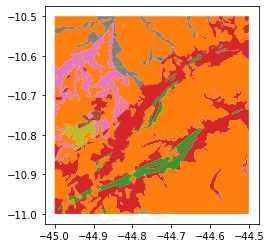

In [10]:
l_rioparaim.plot('SIGLA')

In [2]:
g_rparaim = pd.read_csv(gdb+'geof/recortado/g_rparaim')

In [3]:
g_rparaim.sort_values('eU')

,X,Y,MDT,KPERC,eU,eth,CTCOR,LONGITUDE,LATITUDE
25821,515104.87,8822663.16,418.16,1.38,-1.03,9.88,840.58,-44.861893,-10.650482
25822,515105.91,8822588.77,420.68,1.32,-0.91,10.84,890.72,-44.861883,-10.651155
38738,524144.66,8807667.88,667.58,1.55,-0.55,10.84,1007.38,-44.779142,-10.786053
25820,515104.28,8822737.52,411.11,1.35,-0.54,8.96,841.25,-44.861898,-10.649809
38739,524145.62,8807593.84,643.39,1.64,-0.47,11.64,1090.95,-44.779133,-10.786723
...,...,...,...,...,...,...,...,...,...
39539,524637.47,8822983.58,468.96,0.07,9.18,16.16,2127.09,-44.774737,-10.647533
18909,510108.47,8805304.95,507.73,0.10,9.27,28.41,2843.09,-44.907528,-10.807489
39542,524635.40,8823218.59,465.78,0.25,10.27,12.74,2126.63,-44.774757,-10.645408
39540,524636.75,8823061.86,468.12,0.10,11.45,15.87,2411.26,-44.774744,-10.646825


In [4]:
data = g_rparaim

coordinates = (g_rparaim.X.values, g_rparaim.Y.values)
coordinates

(array([500020.25, 500103.83, 500187.24, ..., 554618.94, 554618.52,
        554617.97]),
 array([8786155.43, 8786158.77, 8786161.64, ..., 8839028.43, 8839107.8 ,
        8839187.24]))

In [36]:
ax = plt.figure()
plt.scatter(data.LONGITUDE,data.LATITUDE,
            c    = data.CTCOR,
            cmap = 'hsv',
            s    = 2)
plt.axis('scaled')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[]

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(data.LONGITUDE,data.LATITUDE,
            c    = data.eU,
            cmap = 'hsv',
            s    = 2)
plt.axis('scaled')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(data.LONGITUDE,data.LATITUDE,
            c    = data.eth,
            cmap = 'hsv',
            s    = 2)
plt.axis('scaled')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
g_rparaim['geometry'] = [geometry.Point(x,y) for x, y in zip(g_rparaim['X'], g_rparaim['Y'])]

In [9]:
# Block Reduction
reducer_median = vd.BlockReduce(np.mean, spacing= 500)
b_coords, b_CTCOR = reducer_median.filter(coordinates, g_rparaim.CTCOR)


# Ploting the Reduced data
plt.figure(figsize=(9,9))
plt.scatter(b_coords[0],b_coords[1],
            c    = b_CTCOR,
            cmap = 'hsv',
            s    = 2)
plt.axis('scaled')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
reducer_mean = vd.BlockReduce(np.mean, spacing= 499)
b_coords, b_CTCOR = reducer_mean.filter(coordinates, g_rparaim.CTCOR)

plt.figure('Spacing 499',figsize=(9,9))
plt.scatter(b_coords[0],b_coords[1],
            c    = b_CTCOR,
            cmap = 'hsv',
            s    = 2)
plt.axis('scaled')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
spline = vd.Spline()

In [12]:
spline.fit(b_coords, b_CTCOR)

/home/ggrl/Softwares/anaconda3/envs/mappingBot/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


Spline()

In [13]:
predicted = spline.predict(coordinates)

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(coordinates[0],coordinates[1],
            c=predicted,
            cmap='magma',
            s=1)
plt.axis('scaled')
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
residuals = g_rparaim.CTCOR - predicted

In [ ]:
scale = vd.maxabs(residuals)

plt.figure(figsize=(8,8))
plt.scatter(coordinates[0],coordinates[1],
            c=residuals,
            cmap='RdBu_r',
            s=2,
            vmin=-scale,vmax=scale)
plt.axis('scaled')
plt.colorbar()

In [ ]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing = 200,pixel_register=True)

In [ ]:
region

In [ ]:
grid_CTCOR = spline.predict(grid_coords)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(grid_coords[0], grid_coords[1],
            c=grid_CTCOR,
            cmap='magma',
            s=2)
plt.axis('scaled')
plt.colorbar()

In [ ]:
grid = spline.grid(spacing=200, data_names=['CTCOR'])
grid

In [ ]:
'''
vmin= grid.CTCOR.quantile([0.25,0.5,0.75])
print(vmin)
'''
grid.CTCOR.plot(figsize=(12,12),
               cmap='hsv',vmin=600, vmax=2000)
plt.axis('scaled')

In [ ]:
grid = vd.distance_mask(coordinates, maxdist=1000, grid=grid)
grid

grid.CTCOR.plot(figsize=(12,12),cmap='hsv')
plt.axis('scaled')

In [ ]:
chain = vd.Chain([
    ('trend',  vd.Trend(degree=1)),
    ('reduce', vd.BlockReduce(np.median, spacing=2000)),
    ('spline', vd.Spline())
])

In [ ]:
g_rparaim.head()

In [ ]:
chain.fit(coordinates, g_rparaim.KPERC)

grid = chain.grid(spacing=400, data_names=['KPERC'])
grid_mask = vd.distance_mask(coordinates, maxdist=2000, grid=grid)

In [ ]:
grid_mask

In [ ]:
grid_mask.KPERC.plot(figsize=(8,8), cmap='hsv',vmin=0)
plt.axis('scaled')

Model Validation

In [ ]:
train, test = vd.train_test_split(coordinates, g_rparaim.CTCOR,
                                 test_size = 0.1)

In [ ]:
train

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train[0][0], train[0][1], '.b', markersize=4)
plt.plot(test[0][0], test[0][1], '.r', markersize=4)
plt.axis('scaled')

In [ ]:
chain_CTCOR.fit(*train)
# *train   ---> chain.fit(train[0], train[1])

In [ ]:
chain_CTCOR.score(*test)

In [ ]:
train, test = vd.train_test_split(coordinates, g_rparaim.CTCOR, test_size=0.1, spacing=1000)

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train[0][0], train[0][1], '.b', markersize=3)
plt.plot(test[0][0], test[0][1], '.r', markersize=3)
plt.axis('scaled')

In [ ]:
chain_CTCOR.fit(*train)

In [ ]:
chain_CTCOR.score(*test)

In [ ]:
cv     = vd.BlockKFold(spacing=1000,
                  n_splits=50,
                  shuffle=True)

In [ ]:
scores = vd.cross_val_score(chain_CTCOR,
                            coordinates,
                            g_rparaim.CTCOR,
                            cv=cv)

In [ ]:
scores

In [ ]:
plt.figure()
plt.hist(scores, bins ='auto')

In [ ]:
geof = CTCOR_grid.to_dataframe()
geof.reset_index(inplace=True)

In [ ]:
geof